## Eigenfaces and Face reconstruction

Load faces.mat. This contains the matrix X with 5000 rows and 1024 columns. The columns are 
the rolled-out 32x32 pixel values of a face image. Try to reshape one row data into 32x32 matrix 
and plot the image using a grayscale colormap. The first 100 faces are shown below.

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import math

In [3]:
mat_contents = scipy.io.loadmat('../raw-data/faces.mat')
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [4]:
faces = mat_contents['X']

In [7]:
def print_face(matrix, row_size=1, column_size=1):
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.rcParams.update({'font.size': 8})
    plt.rcParams['figure.constrained_layout.use'] = True
            
    img = plt.imshow(matrix)
    img.set_cmap('gray')
    plt.axis('off')
    plt.show()

In [133]:
def print_faces(faces,N = 100, column_size = 10):
    w = faces.shape[1]
    n = m = int(math.sqrt(w))
    row_size = int(N/column_size)
    count = 0
    allPersons = np.zeros((n*row_size,m*column_size))
    while count < N:
        for i in range(row_size):
            for j in range(column_size):
                allPersons[i*n : (i+1)*n, j*m : (j+1)*m] = faces[count,:].reshape(n,m).T
                count += 1

    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.rcParams.update({'font.size': 8})
    plt.rcParams['figure.constrained_layout.use'] = True
            
    img = plt.imshow(allPersons)
    img.set_cmap('gray')
    plt.axis('off')
    plt.show()

In [102]:
faces.shape

(5000, 1024)

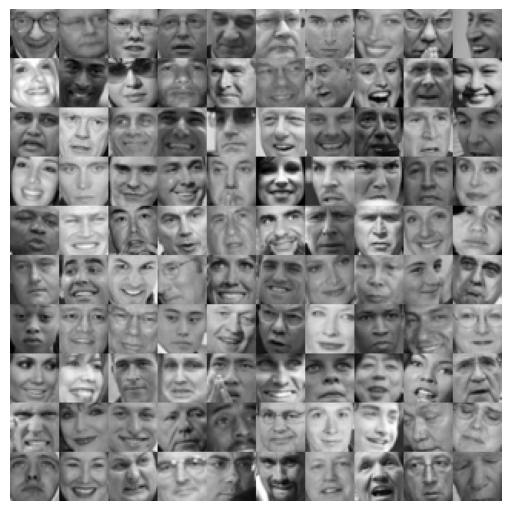

In [134]:
print_faces(faces, N=100)

### SVD on X

Perform SVD on X, identify the eigenfaces and plot the first few of them. Note that these 
eigenvectors correspond to eigenvalues with large values which together explains most of the 
variation in the data. Below are the first 36 eigenfaces. 

In [5]:
#I'll be using 70-30 split
faces_70 = int(faces.shape[0]*.7)
indices = np.random.permutation(faces.shape[0])
training_idx, test_idx = indices[:faces_70], indices[faces_70:]
training_faces, test_faces = faces[training_idx,:], faces[test_idx,:]

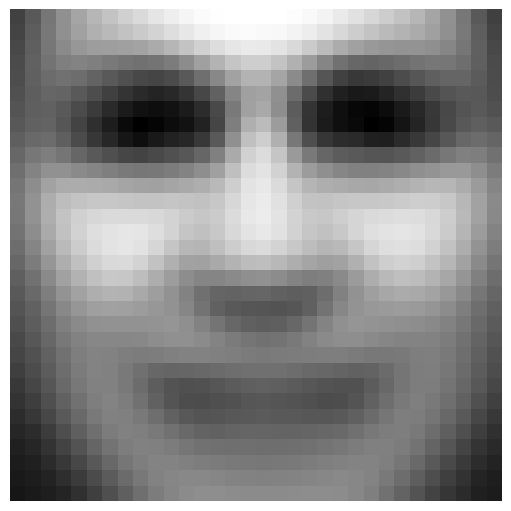

In [104]:
average_face = np.mean(training_faces, axis=0)
print_face(np.reshape(average_face,(32,32)).T)

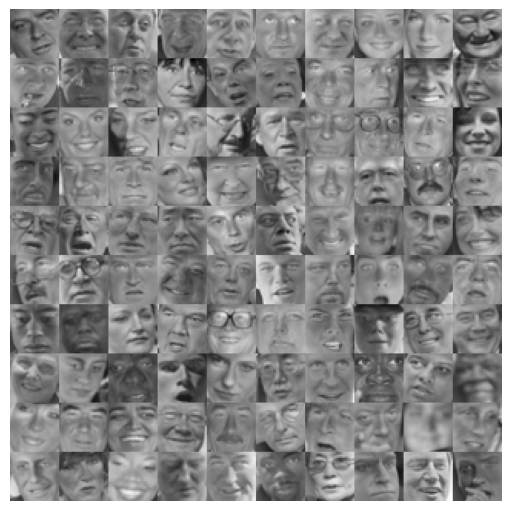

In [107]:
X = training_faces - average_face
print_faces(X, N=100)

In [202]:
def sv_decomposition(matrix, relative_rank = 1):
    m, n = matrix.shape
    s = min(m,n)

    #Compute for ATA
    ATA = np.dot(matrix.T, matrix)

    #Compute for Eigenvalues and Eigenvectors
    eigenvalues_ATA, V = np.linalg.eig(ATA)

    # Apply dimensionality reduction
    eigenvalues_ATA = eigenvalues_ATA[:s]
    V = V[:, :s]

    #Sort Eigenvalues and V by eigenvalues in descending order
    sort_desc = np.argsort(eigenvalues_ATA)[::-1]
    
    eigenvalues_ATA = eigenvalues_ATA[sort_desc]
    V = V[:, sort_desc]

    #Square root of eigenvalues, is Sigma
    S = np.diag(np.sqrt(eigenvalues_ATA))
    S_inv = np.linalg.inv(S)

    #Compute U as U = AVS^-1.
    U = np.dot(matrix, np.dot(V, S_inv))

    if relative_rank < 1:
        compressed = int(math.sqrt(int(1024*relative_rank)))**2
        return U[:,:compressed], np.diag(np.diag(S)[:compressed]), V.T[:compressed,:]
        
    return U, S, V.T


In [218]:
# Perform SVD
U, S, VT = sv_decomposition(X.T, relative_rank=1)
#U1, S1, VT1 = np.linalg.svd(X.T, full_matrices=True)

C:\Users\Jouh\AppData\Local\Temp\ipykernel_37468\1162343452.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  allPersons[i*n : (i+1)*n, j*m : (j+1)*m] = faces[count,:].reshape(n,m).T


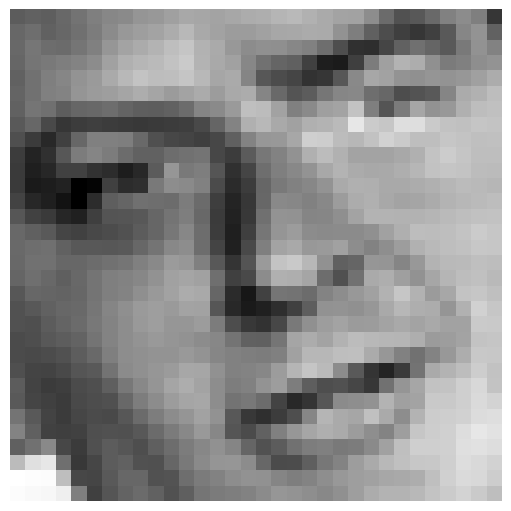

In [219]:
reconstimg = U @ (S @ VT)
print_faces(reconstimg.T, N=1, column_size=1)

C:\Users\Jouh\AppData\Local\Temp\ipykernel_37468\1162343452.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  allPersons[i*n : (i+1)*n, j*m : (j+1)*m] = faces[count,:].reshape(n,m).T


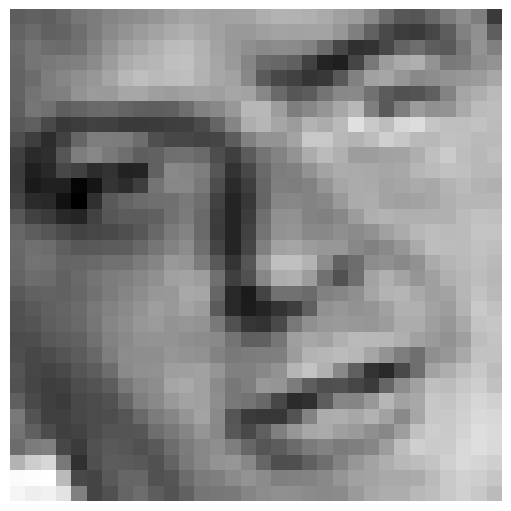

In [217]:
reconstimg = U @ (S @ VT)
print_faces(reconstimg.T, N=1, column_size=1)

C:\Users\Jouh\AppData\Local\Temp\ipykernel_37468\1162343452.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  allPersons[i*n : (i+1)*n, j*m : (j+1)*m] = faces[count,:].reshape(n,m).T


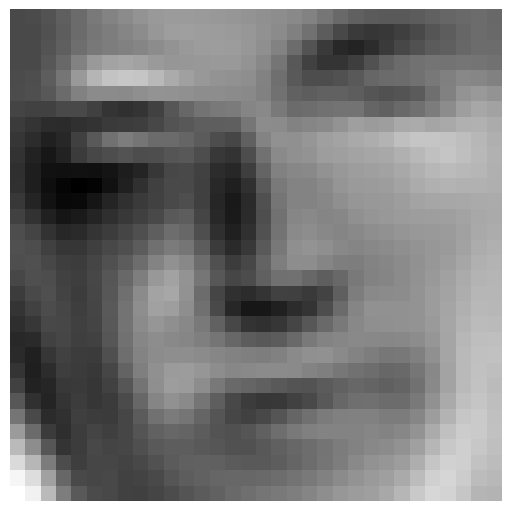

In [215]:
reconstimg = U @ (S @ VT)
print_faces(reconstimg.T, N=1, column_size=1)

C:\Users\Jouh\AppData\Local\Temp\ipykernel_37468\3369085154.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  allPersons[i*n : (i+1)*n, j*m : (j+1)*m] = faces[count,:].reshape(n,m).T


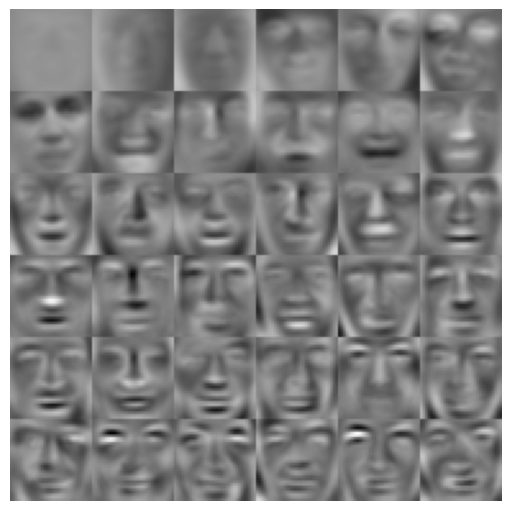

In [127]:
print_faces(U.T, N=36, column_size=6)

### a. Observe what features are represented by the first few eigenfaces. 

C:\Users\Jouh\AppData\Local\Temp\ipykernel_20816\1591993088.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  allPersons[i*n : (i+1)*n, j*m : (j+1)*m] = faces[count,:].reshape(n,m).T


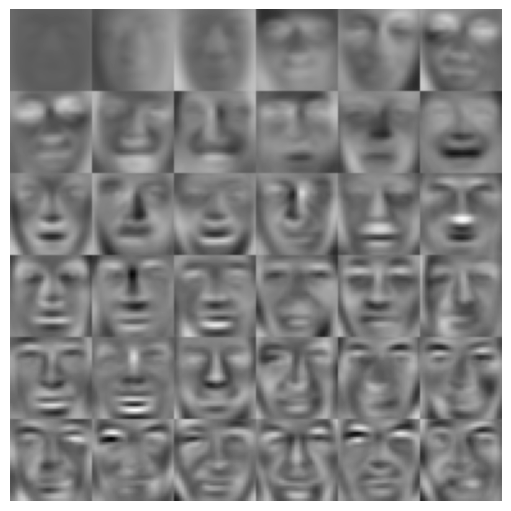

In [175]:
print_faces(U.T, N=36, column_size=6)

For the first pictures presented by eigenfaces:
- First Eigenface: Represents the overall average lighting and shadow patterns in the faces.
- Second Eigenface: Captures variations in the overall horizontal features of the faces, such as the position of the eyes and width of the face.
- Third Eigenface: Highlights the vertical features, such as the position of the mouth and height of the face.
- Subsequent Eigenfaces: Capture more localized features such as the presence and shape of facial features (e.g., nose, mouth, eyes) and other finer details.




### b. Discuss how dimensionality reduction is performed and what is the rationale of doing dimensionality reduction.
We use the PCA technique which is standardization, which normalize the data to have zero mean and unit variance. But we only use to subtract the computed average face to each column vector.

This causes that each variable has a mean of zero. This centering is necessary because PCA is sensitive to the mean of the data. If the data is not centered, the first principal component might capture the mean of the data rather than the direction of maximum variance.

Thus, this ensures that the eigenfaces (principal components) effectively capture the most significant variations in facial features, leading to a more efficient and accurate facial recognition system.

c:\Users\Jouh\Documents\Works\ai-linearalgebra-probsets\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Jouh\Documents\Works\ai-linearalgebra-probsets\.venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'log singular values')

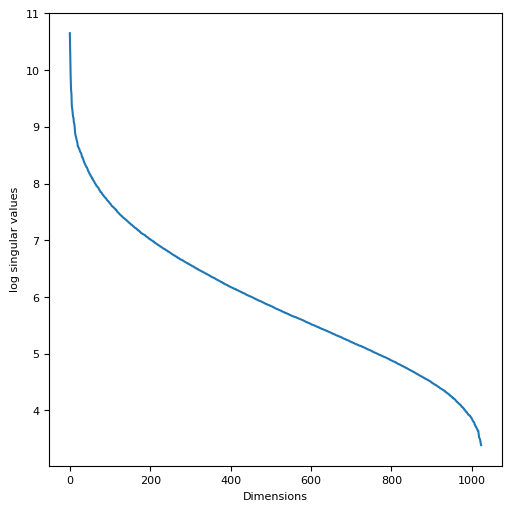

In [58]:
#Plot of our Singular Values:
plt.rcParams.update({'font.size': 8})
plt.rcParams['figure.figsize'] = [5,5]
plt.plot(np.log(np.diag(S)))
plt.xlabel("Dimensions")
plt.ylabel("log singular values")


In [191]:
S

array([4.24061859e+04, 2.84073552e+04, 1.97269573e+04, ...,
       3.23318724e+01, 3.14795791e+01, 3.07205415e+01])

In [185]:
sig_med = np.median(S)
beta = 32/32
omega = 0.56*beta**3 - 0.95*beta**2 + 1.82*beta + 1.43
tou = omega*sig_med
print("Value of Tou = ",tou)
print("Now we need to eliminate all singular values < ",tou)

Value of Tou =  0j
Now we need to eliminate all singular values <  0j


In [63]:
S

array([42406.18588179, 28407.35523332, 19726.95734254, ...,
                  nan,            nan,            nan])

### c. Discuss how compression is achieved using SVD. Reconstruct the faces using the first k eigenfaces and compute the error of reconstruction averaged over all the faces. Plot the average reconstruction error versus k from 1 to 100. 